In [ ]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
import keras
from tqdm import tqdm

In [3]:
data_dir = "../data/Balanced_Train_Detection/"
# Load the training CSV file
train_csv = pd.read_csv(os.path.join(data_dir, "Train.csv"))

# Number of unique classes (should be 43)
nb_classes = train_csv["ClassId"].nunique()
print("Number of classes:", nb_classes)

classes = {
    0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)',
    9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection',
    12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 16:'Veh > 3.5 tons prohibited',
    17:'No entry', 18:'General caution', 19:'Dangerous curve left', 20:'Dangerous curve right',
    21:'Double curve', 22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right',
    25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing',
    29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing',
    32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead',
    35:'Ahead only', 36:'Go straight or right', 37:'Go straight or left', 38:'Keep right',
    39:'Keep left', 40:'Roundabout mandatory', 41:'End of no passing', 42:'End no passing veh > 3.5 tons'
}
# Create a mapping: classid -> class name
class_names_label = classes
# Example lookup
print("Class 2 means:", class_names_label[3])

Number of classes: 43
Class 2 means: Speed limit (60km/h)


In [4]:
IMAGE_SIZE = (64, 64)
def load_data(df, base_dir):
    images = []
    labels = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(base_dir, row["Path"])
        label = row["ClassId"]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE)

        # Normalization
        image = image.astype("float32") / 255.0

        images.append(image)
        labels.append(label)
    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")
    return images, labels
# load
train_csv = pd.read_csv(os.path.join(data_dir, "Train1.csv"))
test_csv  = pd.read_csv(os.path.join(data_dir, "Test.csv"))

train_images, train_labels = load_data(train_csv, data_dir)
test_images, test_labels = load_data(test_csv, data_dir)

100%|██████████| 12630/12630 [00:11<00:00, 1115.77it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples:", n_train)
print("Number of testing examples:", n_test)
print("Each image is of size:", IMAGE_SIZE)

Number of training examples: 86000
Number of testing examples: 12630
Each image is of size: (64, 64)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.15, random_state=44, stratify=train_labels
)
X_test,y_test = (test_images, test_labels)

In [8]:
import tensorflow as tf

model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (5, 5), activation="relu", input_shape=(64, 64, 3)
        ),
        tf.keras.layers.Conv2D(64, (5, 5), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.Conv2D(256, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.20),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(43, activation="softmax", dtype="float32"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

d:\AI-MachineLearning\Ml-project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,319,659 (73.70 MB)

 Trainable params: 19,319,659 (73.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size = 128,
    epochs = 10,
    validation_data=(X_val, y_val),
    )
    # 5 Ephochs is Very Good

Epoch 1/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 825s 1s/step - accuracy: 0.8128 - loss: 0.6424 - val_accuracy: 0.9842 - val_loss: 0.0557
Epoch 2/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 762s 1s/step - accuracy: 0.9792 - loss: 0.0672 - val_accuracy: 0.9911 - val_loss: 0.0287
Epoch 3/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 800s 1s/step - accuracy: 0.9873 - loss: 0.0388 - val_accuracy: 0.9958 - val_loss: 0.0139
Epoch 4/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 789s 1s/step - accuracy: 0.9893 - loss: 0.0328 - val_accuracy: 0.9926 - val_loss: 0.0250
Epoch 5/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 771s 1s/step - accuracy: 0.9913 - loss: 0.0275 - val_accuracy: 0.9905 - val_loss: 0.0292
Epoch 6/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 812s 1s/step - accuracy: 0.9925 - loss: 0.0244 - val_accuracy: 0.9947 - val_loss: 0.0172
Epoch 7/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 827s 1s/step - accuracy: 0.9923 - loss: 0.0244 - val_accuracy: 0.9947 - val_loss: 0.0203
Epoch 8/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - accuracy: 0.9950 - loss: 0.0171 - val_accu

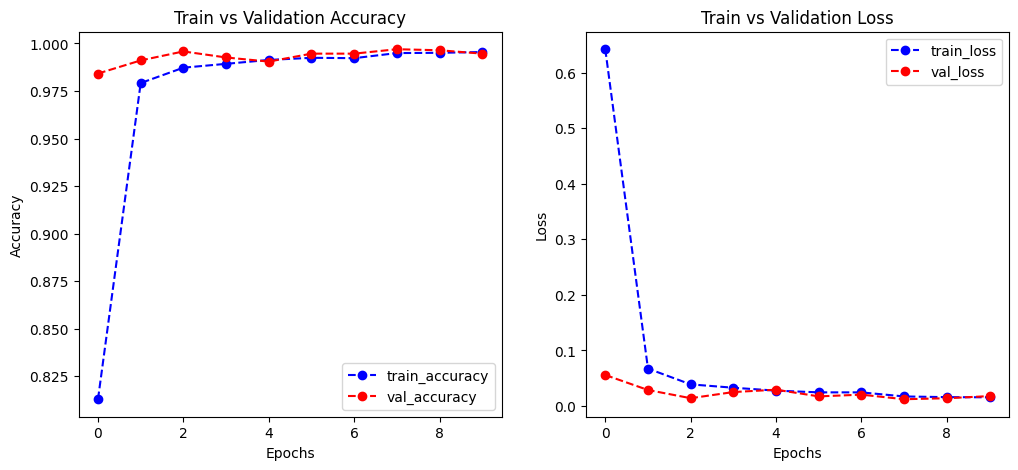

In [10]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(12,5))

    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], 'bo--', label='train_accuracy')
    plt.plot(history.history['val_accuracy'], 'ro--', label='val_accuracy')
    plt.title("Train vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], 'bo--', label='train_loss')
    plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
    plt.title("Train vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()
plot_accuracy_loss(history=history)

In [11]:
pred_probs = model.predict(test_images)         
pred_labels = np.argmax(pred_probs, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step


In [12]:
classes = [str(i) for i in range(43)]

print("Classification Report:")
print(classification_report(test_labels, pred_labels, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        60
           1       0.90      0.93      0.91       720
           2       0.96      0.78      0.86       750
           3       0.83      0.90      0.86       450
           4       0.99      0.89      0.94       660
           5       0.72      0.82      0.76       630
           6       0.98      0.78      0.87       150
           7       0.79      0.90      0.84       450
           8       0.95      0.94      0.95       450
           9       1.00      0.79      0.88       480
          10       0.89      0.91      0.90       660
          11       0.88      0.89      0.88       420
          12       0.98      0.95      0.96       690
          13       0.99      0.97      0.98       720
          14       1.00      0.98      0.99       270
          15       0.91      1.00      0.95       210
          16       0.86      0.99      0.92       150
    

In [13]:
loss, acc = model.evaluate(test_images, test_labels, verbose=0)
print("Test accuracy:", acc)

Test accuracy: 0.8778305649757385


In [16]:
model.save("../models/LastVersionCnn.keras")